# rco2: Three-dimensional (color) charting

## Oregon Slope Base, shallow profiler curtains
### 01-JAN through 01-MAR 2017

Shallow profilers (Science Pods, SCIPs) begin at 200 meters depth and rise to the surface nine times per day. 
They are positively buoyant and rise and fall by means of a cable and a winch. They collect data along the way. 
Each rise/fall cycle is called a *profile*. Two of the nine profiles are slightly different in character. They 
pause on the descent portion at a set of fixed depths to allow the nitrate sensor to make a stable measurement. 
This is apparent in a stair-step character to the time/pressure chart. 


If we plot shallow profiler data with the y-axis corresponding to depth for one day we will see the individual
profiles. If we compress many weeks of data onto a single chart the time axis will have more work to do; so the
data are compressed together and come to resemble a curtain. A third type of data from the choices
{ salinity, dissolved oxygen, temperature } can be color-coded to produce a water-column profile curtain. 
This is our goal here; using the yodapy OOI object as the means of data access.

Each sub-section here is preceded by some explanation

### Python utility code

These functions are used to simplify the data management. One of the tasks here is to use the data request
to generate a software 'link' to the resulting data. This precedes loading the data into memory.

In [1]:
%matplotlib inline
!pip install utm
!pip install pygeotools
import timeit, pandas as pd, netCDF4, xarray as xr, dask, numpy as np, sys, os, utm, golive_utility as g
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ipywidgets import *
from traitlets import dlink
np.warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Intermezzo: Timing Jupyter notebook cell execution time

There are some 'Jupyter notebook magic' features line magic ('%') and cell magic ('%%'). 
See [this link](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for more.

Let's use the 'time'
line magic to time the running of a trivial cell, as follows...

In [59]:
# the 'time' line magic prints 'how long I took to run'. If this cell has been pre-run the output 'wall time' will be 
#   a guide to the new user on how long the cell *ought* to take. However there is a catch: The cells may run in an
#   asynchronous manner meaning that the %time will tell us how long it took to "fire everything off" without telling us 
#   how long it took for the task to be completed. 
%time

# try it; notice the print substitutes a space for a carriage return via the end kwarg 
for i in range(1,100): print(i,end = " ")


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

## Data Request

This section uses the 'yodapy' package to create an OOI object called 'ooi'. This in turn is configured 
using a 'search' method to point at a specific sub-region of the **RCO** data.

In [60]:
# object to interface with OOI
from yodapy.datasources import OOI

# see progress info from yodapy
import logging
logging.basicConfig(level=logging.INFO)

ooi = OOI()
# search by research array, site, and instrument name or reference designator
# functions like google searches

# everything on the profiler: http://ooi.visualocean.net/sites/view/RS01SBPS
# ooi.search(region="cabled",site="oregon slope base",instrument="ctd")
# 
# Please observe: This CTD produces *4* results: temperature, salinity and dissolved oxygen w/r/t depth
#
ooi.search(region="cabled",site="oregon slope base shallow profiler",instrument="RS01SBPS-SF01A-2A-CTDPFA102")
ooi.view_instruments()

INFO:yodapy.datasources.ooi.m2m_client:Creating M2mClient instance (https://ooinet.oceanobservatories.org)


,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


{'RS01SBPS-SF01A-2A-CTDPFA102': [{'beginTime': '2014-10-06T22:05:23.269Z',
   'count': 97236022,
   'endTime': '2018-12-21T01:49:54.365Z',
   'method': 'streamed',
   'stream': 'ctdpf_sbe43_sample'}]}

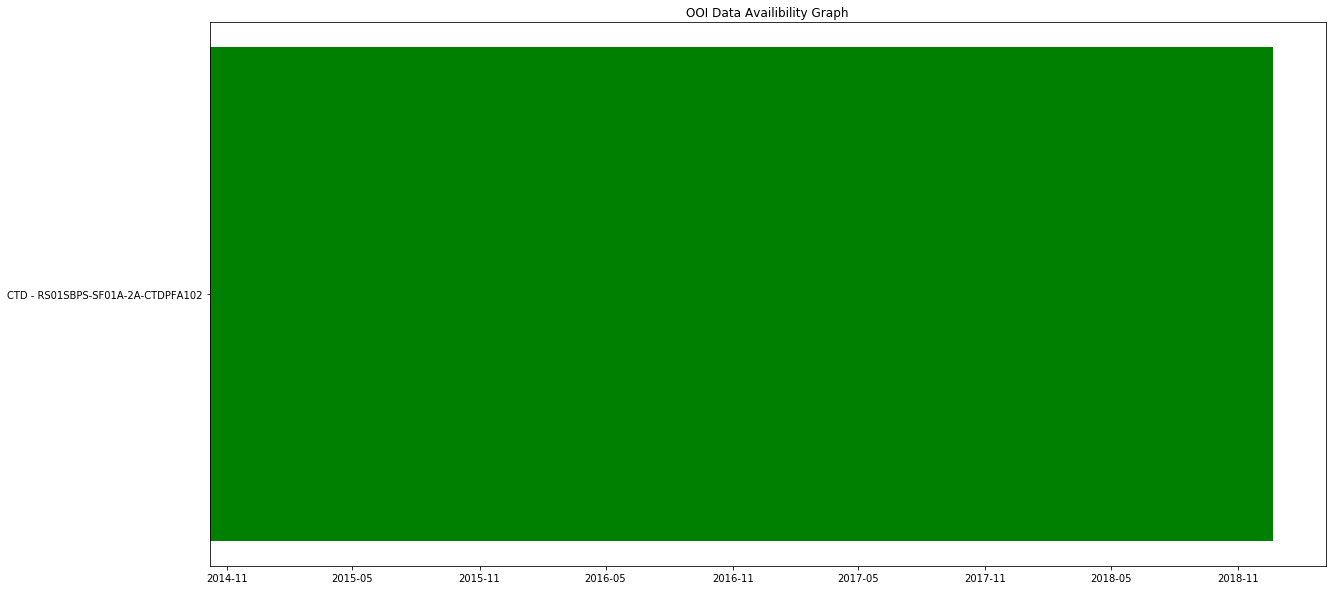

In [3]:
# notice we have dialed in (so far) to region, site and insrument
# comment out to skip viewing the data availability plot for this instrument
# The '%%' syntax Keenan referred to as 'magic' { line magic uses '%', cell magic uses '%%'}
#   ...see https://ipython.readthedocs.io/en/stable/interactive/magics.html

%matplotlib inline
ooi.data_availability()
# i just see a green block so the chart is not particularly helpful

In [6]:
%time                     # This does not help particularly; see note above on asynchronous processes
begin = "2017-01-01"
end = "2017-03-01"
asset = ooi.request_data(begin_date = begin, end_date = end, data_type = "netcdf")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


INFO:yodapy.datasources.ooi:Requesting data ...
INFO:yodapy.datasources.ooi:Data request complete, please wait for data to be compiled ...


In [7]:
# Print this to see the data compile in real time
# asset.raw()[0]["allURLs"]

# ...or in automated fashion: This took a minute on Dec 20 2018 and %time did not help (see note above on asynchronous)
%time
import time
while not ooi.check_status(): time.sleep(5)
print("Request complete!")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T031600-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.


Request complete!


In [9]:
# dirobj(ooi)
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [12]:
dirobj(asset)

['check_status',
 'clear',
 'data_availability',
 'download_ncfiles',
 'end_date',
 'last_request_urls',
 'raw',
 'request_data',
 'search',
 'source_name',
 'start_date',
 'to_xarray',
 'token',
 'username',
 'view_instruments',
 'view_regions',
 'view_sites']

In [19]:
asset.check_status()
# we really need to move forward from this point: bootstrapping the streams, assigning those...

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [13]:
asset.data_availability()

{'RS01SBPS-SF01A-2A-CTDPFA102': [{'beginTime': '2014-10-06T22:05:23.269Z',
   'count': 97241503,
   'endTime': '2018-12-21T03:21:15.489Z',
   'method': 'streamed',
   'stream': 'ctdpf_sbe43_sample'}]}

In [18]:
# This pulls down a 170MB file
%time
asset.download_ncfiles(data+'ooi')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T031600-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.
INFO:yodapy.datasources.ooi:Downloading netcdf data ...


['https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20181221T031600-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html']


INFO:yodapy.datasources.ooi.helpers:Downloading deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170101T000000.678980-20170130T014303.019857.nc...
INFO:yodapy.datasources.ooi.helpers:Writing deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170101T000000.678980-20170130T014303.019857.nc...


[['deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170101T000000.678980-20170130T014303.019857.nc']]

In [25]:
asset.last_request_urls     # this item 'last_request_urls' is a list, not a method; 
                            #   and it is a nice snapshot of what we requested above

['https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPS/SF01A/2A-CTDPFA102/streamed/ctdpf_sbe43_sample?beginDT=2017-01-01T00:00:00.000000Z&endDT=2017-03-01T00:00:00.000000Z&format=application/netcdf&limit=-1&execDPA=true&include_provenance=true&user=OOIAPI-SOFYMOGBVIWV7U']

In [27]:
asset.source_name

'OOI'

In [29]:
asset.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [30]:
asset.view_regions()

,reference_designator,name,latitude,longitude
0,CE,Coastal Endurance,44.3700,-124.9500
1,CP,Coastal Pioneer,40.1000,-70.8800
2,GA,Global Argentine Basin,-42.5073,-42.8905
3,GI,Global Irminger Sea,60.4582,-38.4407
4,GP,Global Station Papa,49.9795,-144.2540
5,GS,Global Southern Ocean,-54.0814,-89.6652
6,RS,Cabled Array,44.5540,-125.3520


In [31]:
asset.view_sites()

,reference_designator,array_name,name,description,min_depth,max_depth,longitude,latitude
0,CE01ISSM,Coastal Endurance,Oregon Inshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,25,-124.095,44.6598
1,CE01ISSP,Coastal Endurance,Oregon Inshore Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,25,-124.096,44.662
2,CE02SHBP,Coastal Endurance,Oregon Shelf Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,79,79,-124.306,44.6371
3,CE02SHSM,Coastal Endurance,Oregon Shelf Surface Mooring,A Surface Mooring is a type of mooring that co...,0,80,-124.304,44.6393
4,CE02SHSP,Coastal Endurance,Oregon Shelf Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,81,-124.299,44.6372
5,CE04OSBP,Coastal Endurance,Oregon Offshore Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,579,579,-124.954,44.3695
6,CE04OSPD,Coastal Endurance,Oregon Offshore Cabled Deep Profiler Mooring,Profiler Moorings are a type of mooring that c...,175,576,-124.953,44.3683
7,CE04OSPS,Coastal Endurance,Oregon Offshore Cabled Shallow Profiler Mooring,Profiler Moorings are a type of mooring that c...,20,588,-124.956,44.3741
8,CE04OSSM,Coastal Endurance,Oregon Offshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,588,-124.956,44.3811
9,CE05MOAS,Coastal Endurance,Mobile Assets,Gliders are buoyancy-driven mobile assets. The...,0,1000,,


In [34]:
# Now we go from an abstract 'asset' to an xarray (more tangible!... but we do need to understand what happens here)
%time
x=asset.to_xarray()
x

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs


INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T031600-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.
INFO:yodapy.datasources.ooi:Acquiring data from opendap urls ...


[<xarray.Dataset>
 Dimensions:                                 (time: 2400702)
 Coordinates:
     obs                                     (time) int32 0 1 2 3 4 5 6 7 8 9 ...
   * time                                    (time) float64 3.692e+09 ...
     seawater_pressure                       (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
     lat                                     (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
     lon                                     (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
 Data variables:
     deployment                              (time) int32 dask.array<shape=(2400702,), chunksize=(2400702,)>
     id                                      (time) |S64 dask.array<shape=(2400702,), chunksize=(2400702,)>
     conductivity                            (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
     driver_timestamp                        (time) float64 dask.array<sh

In [43]:
# We hope that 'x' is a list of xarray objects that "know everything" so let's try and save it as a file and compare the 
#   file size to the results of the prior save.
# x[0]
# sadly this does not run properly:
# x[0].to_netcdf(data+'ooi/xarray_test_save')
# So uncomment it to see the warning and the error

In [83]:
# This cell associates xx (an xarray) with the completed dataset from above.
#   ooi.to_xarray() returns a list of Datasets for our instrument; in this case (with the CTD)... kilroy left off here

%time
DO = None
Time = None
Pressure = None
Temperature = None
Salinity = None
count = 0
# to_xarray() returns a list of xarray Datasets for each instrument (stream?)
# since we only have one instrument, we subscript it to unwrap the data
# but this code (commented out) throws a logic error 'the truth value of an array...'
# so I will replace it with something more direct
# while not (DO and Time and Pressure and Temperature and Salinity):
#     xx = asset.to_xarray()[0]
#     count += 1
#     if (0. not in xx.corrected_dissolved_oxygen.values): DO = xx.corrected_dissolved_oxygen.values
#     if (0. not in xx.seawater_pressure.values): Pressure = xx.seawater_pressure.values
#     if (0. not in xx.time.values): Time = xx.time.values
#     if (0. not in xx.seawater_temperature.values): Temperature = xx.seawater_temperature.values
#     if (0. not in xx.practical_salinity.values): Salinity = xx.practical_salinity.values
#
# This section of code seems to work just fine...
xx = asset.to_xarray()[0] 
DO = xx.corrected_dissolved_oxygen.values
Pressure = xx.seawater_pressure.values
Time = xx.time.values
Temperature = xx.seawater_temperature.values
Salinity = xx.practical_salinity.values
print(DO.any(),Time.any(),Pressure.any(),Temperature.any(), Salinity.any(), sep=" -- ")

# this is throwing an error on the 'while' which makes sense because i don't know how this even works

SyntaxError: invalid syntax (<ipython-input-83-15c23d9c0c40>, line 4)

### Now examine these data

Everything up to this point has been about a query and downloading data into RAM for further consideration.
The numpy arrays are called DO, Pressure, Time, Temperature and Salinity. Let's first make sure that they 
are all the same length (this will be along the time axis) so we can chart them against one another.
Thus we finally get to turn the corner to look at the data and determine if it makes some sort of sense. Hurray!! 

In [64]:
# Notice we requested
print(len(DO), len(Pressure), len(Time), len(Temperature), len(Salinity))

2400702 2400702 2400702 2400702 2400702


In [65]:
DO

array([110.43246454, 110.23840414, 110.38948527, ..., 261.87093591,
       261.84708291, 261.91488265])

In [66]:
Pressure

array([191.95034858, 191.95463878, 191.96000153, ...,  62.89325688,
        62.76685992,  62.69938897])

In [67]:
Time

array([3.69221760e+09, 3.69221760e+09, 3.69221760e+09, ...,
       3.69472938e+09, 3.69472938e+09, 3.69472938e+09])

In [68]:
Temperature

array([ 7.73250989,  7.73275569,  7.73263279, ..., 10.29273615,
       10.29266959, 10.29273615])

In [69]:
Salinity

array([33.92359397, 33.92295404, 33.92320398, ..., 32.75775149,
       32.75767702, 32.757772  ])

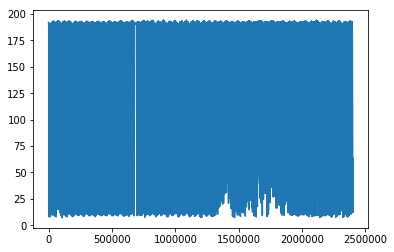

In [70]:
from matplotlib import pyplot as plt
plt.plot(Pressure)

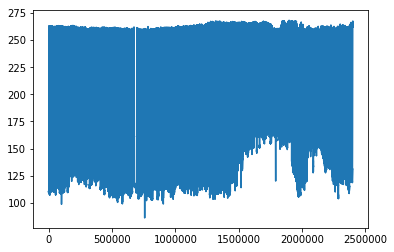

In [71]:
plt.plot(DO)

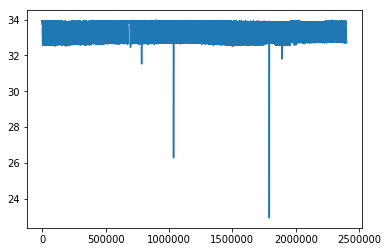

In [72]:
plt.plot(Salinity)

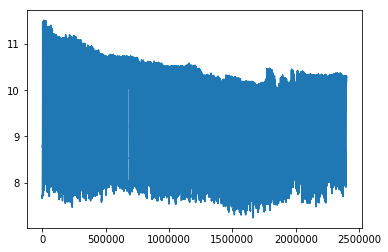

In [73]:
plt.plot(Temperature)

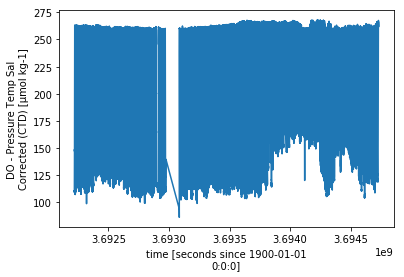

In [74]:
x[0].corrected_dissolved_oxygen.plot()

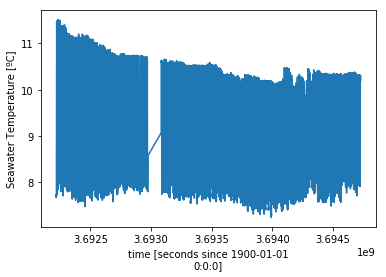

In [75]:
x[0].seawater_temperature.plot()

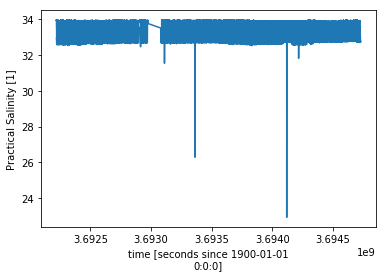

In [76]:
x[0].practical_salinity.plot()

In [77]:
# a reminder on logical evaluation of an expression...
bool(None)

False

## Filter Data

Xarray enables us to see the data without downloading it into memory. In our case, the size of the entire dataset is more than 16 GB! By filtering, we save RAM and download time.

In [79]:
# Since x is a list of (exactly one) xarray datasets I will set 'xa' to simply be that single dataset. 
# We can verify that data is sensible by taking a peek. Behind the scenes this pulls the relevant data
#   from the server.

xa = x[0]
xa.seawater_pressure.values[:10]

array([191.95034858, 191.95463878, 191.96000153, 191.96643683,
       191.97179958, 191.97501723, 191.97930743, 191.98037363,
       191.97822853, 191.97715598])

In [80]:
# Now let us work towards curtain plots of DO, salinity and temperature
namesDO   = ["seawater_pressure","corrected_dissolved_oxygen"]
namesTemp = ["seawater_pressure","seawater_temperature"]
namesSal  = ["seawater_pressure","practical_salinity"]

# the chunk() call cuts the array into pieces along the time dimension for faster processing
xbDO   = xa[["time"] + namesDO].chunk(chunks={"time" : 1000})
xbTemp = xa[["time"] + namesTemp].chunk(chunks={"time" : 1000})
xbSal  = xa[["time"] + namesSal].chunk(chunks={"time" : 1000})

In [85]:
# convert netcdf to pandas data frame
# now we are actually downloading into RAM so the data are immediately to hand
# this does not work: frame = xa.to_dataframe()
# I get 'Runtime error: NetCDF: DAP failure'
# So let's work with 'xx' which is the xarray we generated earlier 
xx

<xarray.Dataset>
Dimensions:                                 (time: 2400702)
Coordinates:
    obs                                     (time) int32 0 1 2 3 4 5 6 7 8 9 ...
  * time                                    (time) float64 3.692e+09 ...
    seawater_pressure                       (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
    lat                                     (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
    lon                                     (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
Data variables:
    deployment                              (time) int32 dask.array<shape=(2400702,), chunksize=(2400702,)>
    id                                      (time) |S64 dask.array<shape=(2400702,), chunksize=(2400702,)>
    conductivity                            (time) float64 dask.array<shape=(2400702,), chunksize=(2400702,)>
    driver_timestamp                        (time) float64 dask.array<shape=(2400702,

In [88]:
# This also fails: Dataset object has no attribute DataArray
# frame = xx.DataArray.to_dataframe()
# This also fails (after a long time):
# frame = xx.to_dataframe()

In [90]:
# for local datasets
import xarray as xr

f = data + 'ooi/' + \
  'deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170101T000000.678980-20170130T014303.019857.nc'
with xr.open_dataset(f) as d:
    frame = d.to_dataframe()

# round pressure for later, not totally necessary right now
frame["seawater_pressure"] = frame["seawater_pressure"].round()
# redundant data slicing
frame = frame[["seawater_pressure","corrected_dissolved_oxygen"]]
print(frame.columns.values)
frame

['seawater_pressure' 'corrected_dissolved_oxygen']


,seawater_pressure,corrected_dissolved_oxygen
obs,,
0,192.0,110.432465
1,192.0,110.238404
2,192.0,110.389485
3,192.0,110.303398
4,192.0,110.347652
5,192.0,110.293146
6,192.0,110.228702
7,192.0,110.338320
8,192.0,110.349999


## Basic Plot

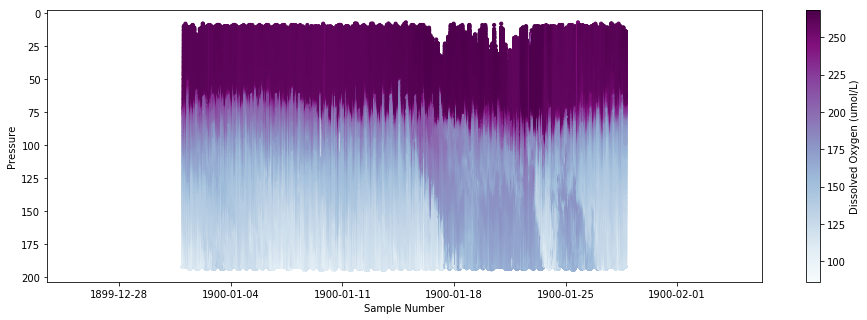

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4  as nc

# we are dealing with 7 million points here, the larger this number, cuts down plotting time
# plotting every (step)-th point
step = 10
fig = plt.figure(figsize=(16,5))
# array slicing sugar: arr[start:stop:step]
s = plt.scatter(nc.num2date(frame.index[::step], "seconds since 1900-01-01"), # x
            frame["seawater_pressure"][::step], # y
            s=10, # thickness
            c=frame["corrected_dissolved_oxygen"][::step], # color map
            cmap=plt.get_cmap("BuPu")) # color style, see others in matplotlib docs
# invert y to show more intuitive perspective
# Remember! Pressure is a proxy for depth!
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Sample Number")
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen (umol/L)")

In [92]:
ooi2 = OOI()

INFO:yodapy.datasources.ooi.m2m_client:Creating M2mClient instance (https://ooinet.oceanobservatories.org)


In [95]:
#lis = [list of reference designators]
#ooi2.search(region="cabled",instrument=",".join(lis))
# use the above to search for all the reference designators in the list

ooi2.search(region="cabled", instrument="RS01SBPS-SF01A-3D-SPKIRA101,RS01SBPS-SF01A-3C-PARADA101")
ooi2.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1227,RS01SBPS-SF01A-3C-PARADA101,Photosynthetically Available Radiation,5.0,200.0,,parad_sa_sample,192,Shallow Profiler
1228,RS01SBPS-SF01A-3D-SPKIRA101,Spectral Irradiance,5.0,200.0,,spkir_data_record,2645,Shallow Profiler


{'RS01SBPS-SF01A-3C-PARADA101': [{'beginTime': '2014-10-07T20:47:48.020Z',
   'count': 430935411,
   'endTime': '2018-12-21T05:46:36.449Z',
   'method': 'streamed',
   'stream': 'parad_sa_sample'}],
 'RS01SBPS-SF01A-3D-SPKIRA101': [{'beginTime': '2014-10-07T20:46:56.410Z',
   'count': 382960573,
   'endTime': '2018-12-21T05:46:38.951Z',
   'method': 'streamed',
   'stream': 'spkir_data_record'}]}

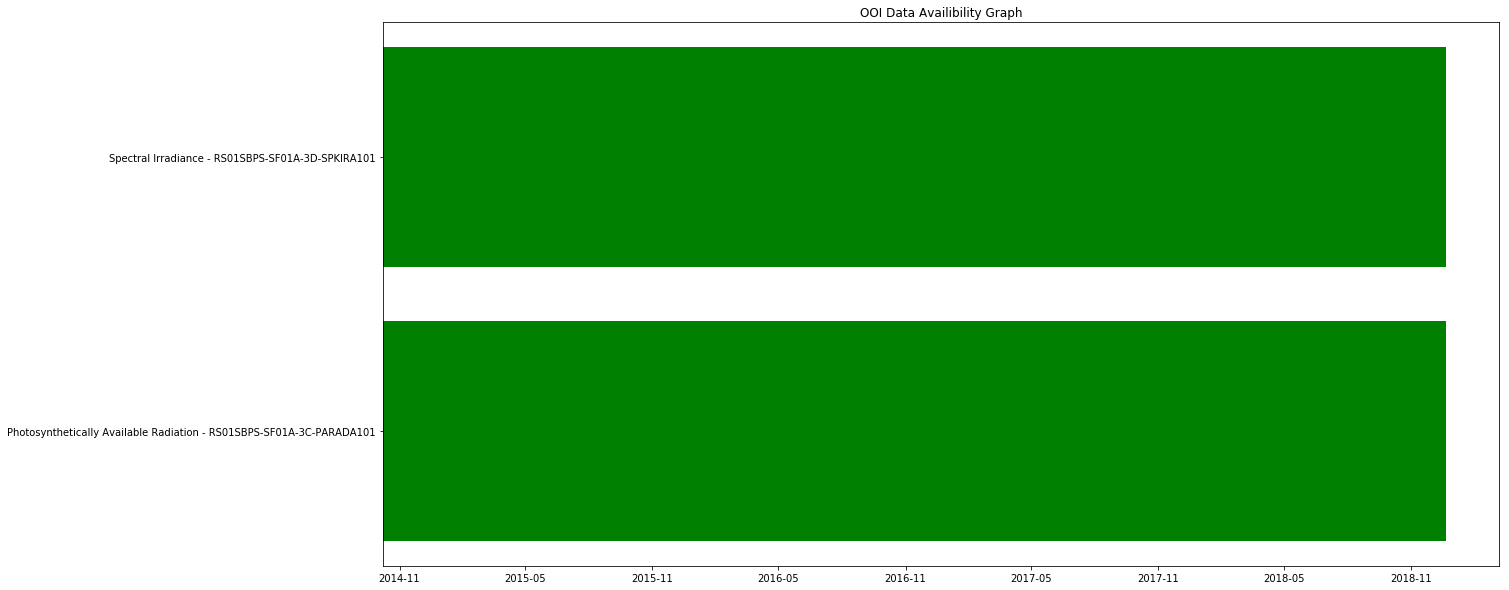

In [96]:
ooi2.data_availability()

In [97]:
ooi2.request_data(
        begin_date = "2017-01-01",
        end_date = "2017-03-01",
        data_type = "netcdf")

INFO:yodapy.datasources.ooi:Requesting data ...
INFO:yodapy.datasources.ooi:Data request complete, please wait for data to be compiled ...


<Data Source: OOI>

In [110]:
xx2 = ooi2.to_xarray()

INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T054649-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample) completed.
INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T054702-RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record) completed.
INFO:yodapy.datasources.ooi:Acquiring data from opendap urls ...


In [112]:
xx2[0].time.values

array([3.69221760e+09, 3.69221760e+09, 3.69221760e+09, ...,
       3.69472938e+09, 3.69472938e+09, 3.69472938e+09])

In [113]:
par = xx2[0].par.values

In [114]:
par4 = par[::4]             # this seems a little arcane / un-documented

In [115]:
l = len(par4)

In [116]:
len(xx2[0].time.values)          # 8 million PAR values

8392448

In [117]:
# now reverting back to the original CTD data in xx
len(xx.time.values)

2400702

In [118]:
xx.time.values[:l]

array([3.69221760e+09, 3.69221760e+09, 3.69221760e+09, ...,
       3.69442679e+09, 3.69442679e+09, 3.69442679e+09])

In [119]:
ind = frame.index[:l]

In [120]:
p = frame["seawater_pressure"].values[:l]

In [121]:
from matplotlib.colors import Normalize as n

In [122]:
len(ind)

2098112

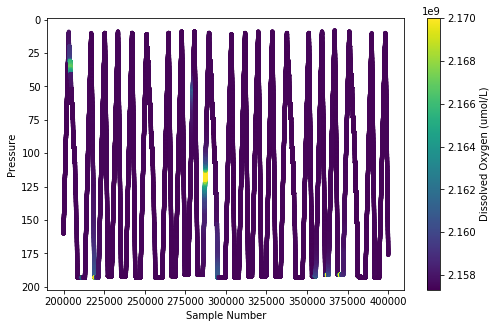

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from matplotlib.colors import Normalize as n
import netCDF4  as nc

# we are dealing with 7 million points here, the larger this number, cuts down plotting time
# plotting every (step)-th point
nor = n(vmax=2.17e9, vmin=min(par4))
step = 1
fig = plt.figure(figsize=(8,5))
# array slicing sugar: arr[start:stop:step]
s = plt.scatter(ind[200000:400000:step], # x
            p[200000:400000:step], # y
            s=10, # thickness
            c=par4[200000:400000:step], # color map
            cmap=plt.get_cmap("viridis"),
            norm=nor) # color style, see others in matplotlib docs
# invert y to show more intuitive perspective
# Remember! Pressure is a proxy for depth!
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Sample Number")
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen (umol/L)")

In [125]:
ind

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            2098102, 2098103, 2098104, 2098105, 2098106, 2098107, 2098108,
            2098109, 2098110, 2098111],
           dtype='int64', name='obs', length=2098112)

In [126]:
xx2[1].spkir_downwelling_vector.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
p

array([192., 192., 192., ..., 171., 171., 171.])

In [128]:
par

array([2.15748518e+09, 2.15747898e+09, 2.15746797e+09, ...,
       2.15746432e+09, 2.15746842e+09, 2.15745453e+09])

In [129]:
ooi3 = OOI()
ooi3.search(region="cabled",instrument="RS01SBPS-SF01A-4A-NUTNRA101")
ooi.view_instruments()

INFO:yodapy.datasources.ooi.m2m_client:Creating M2mClient instance (https://ooinet.oceanobservatories.org)


,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [130]:
ooi3.request_data(
    begin_date = "2017-01-01",
    end_date = "2017-03-01",
    data_type = "netcdf")

INFO:yodapy.datasources.ooi:Requesting data ...
INFO:yodapy.datasources.ooi:Data request complete, please wait for data to be compiled ...


<Data Source: OOI>

In [131]:
nitrate = ooi3.to_xarray()[0]

INFO:yodapy.datasources.ooi:Time elapsed: 10s
INFO:yodapy.datasources.ooi:Time elapsed: 20s
INFO:yodapy.datasources.ooi:Time elapsed: 30s
INFO:yodapy.datasources.ooi:Time elapsed: 41s
INFO:yodapy.datasources.ooi:Time elapsed: 51s
INFO:yodapy.datasources.ooi:Time elapsed: 62s
INFO:yodapy.datasources.ooi:Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181221T061033-RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample) completed.
INFO:yodapy.datasources.ooi:Acquiring data from opendap urls ...


In [133]:
nitrate.salinity_corrected_nitrate.values

array([28.13196659, 27.96947343, 28.11719832, ...,  4.48194273,
        4.60688412,  4.38088833])

In [134]:
salnit = nitrate.salinity_corrected_nitrate.values

In [135]:
nitrate.time.values

array([3.69224414e+09, 3.69224414e+09, 3.69224418e+09, ...,
       3.69471518e+09, 3.69471522e+09, 3.69471522e+09])

In [137]:
nframe = nitrate.to_dataframe()

In [139]:
# Rob got this far on 12/20/2018 where the error here should be fixed by looking above where a frame
#   was cast from xx. There is a lot of redundancy in this notebook; it is rather stream-of-consciousness
#   and very poorly documented. It does go for three related datasets on the SCIP: CTD, PAR and nitrate; 
#   so there is great potential for a good comparison of "3D" plots. 
#
# At this point skip down to the "Depth Averaged" section for some more cells that run
ctdframe = xx.to_dataframe()

RuntimeError: NetCDF: DAP failure

In [118]:
import numpy as np

def round_dataframe(frame,precision=0):
    '''Rounds index to precision numbers after the decimal.'''
    frame.index = frame.index.to_series().apply(lambda x: np.round(x,precision))
    # remove any duplicates for instruments with sampling rate > 1Hz
    return frame[~frame.index.duplicated(keep="first")]

In [119]:
ctdframe = round_dataframe(ctdframe)

In [129]:
nindex = list(zip(*nframe.index.values))[0]

In [130]:
ctdpoints = ctdframe.loc[nindex,:]

C:\Users\ganzk\Anaconda3\envs\yodapy\lib\site-packages\pandas\core\indexing.py:870: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


In [131]:
len(ctdpoints) == len(nframe)

True

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from matplotlib.colors import Normalize as n
import netCDF4  as nc

# we are dealing with 7 million points here, the larger this number, cuts down plotting time
# plotting every (step)-th point
step = 1
fig = plt.figure(figsize=(8,5))
# array slicing sugar: arr[start:stop:step]
s = plt.scatter(ctdpoints.index.values, # x
            ctdpoints["seawater_pressure"], # y
            s=10, # thickness
            c=nframe["salinity_corrected_nitrate"], # color map
            cmap=plt.get_cmap("viridis"),
            norm=nor) # color style, see others in matplotlib docs
# invert y to show more intuitive perspective
# Remember! Pressure is a proxy for depth!
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Sample Number")
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen (umol/L)")

NameError: name 'ctdpoints' is not defined

<Figure size 576x360 with 0 Axes>

Why the large white block in the middle of our data? If there is a connection issue between the profiler and the shore, the instrument will automatically stop oscillating. On rarer occasions, mechanical failure (likely the above) can cause longer outages. Fortunately, these holes are rare and do not prevent plotting the rest of the data.

## Depth Averaged

Above, we see a nice correlation between depth (synonym for pressure) and DO as we would expect. Although nice, what if there were an anomalous increase or decrease in DO at a particular depth that could harm marine life? To suss out this kind of information, we replot the data above but color-code it by comparing it to all other data points at the same depth.

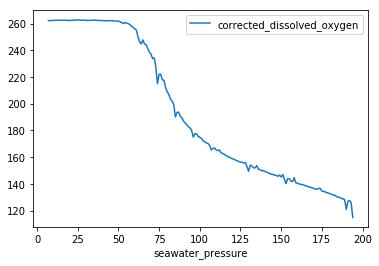

In [140]:
# group datapoints by depth and then take the mean of DO for each group
avgdo = frame.groupby("seawater_pressure").mean()["corrected_dissolved_oxygen"]
avgdo.plot(y="corrected_dissolved_oxygen",legend=True)

In [141]:
# effectively a dictionary linking pressure with DO average
avgdo[20.0]

262.22188112198256

In [142]:
%%time

# This runs fairly slow (minutes); perhaps optimize it
def compute_diff(r):
    return r["corrected_dissolved_oxygen"] - avgdo[r["seawater_pressure"]]

frame2 = frame.apply(compute_diff,axis=1)

CPU times: user 2min 14s, sys: 0 ns, total: 2min 14s
Wall time: 2min 16s


The cell below is helpful for making sure our color-coding does not bias towards either extreme by forcing pure white to align with zero variation from the mean.

In [144]:
from matplotlib.colors import Normalize as n
import numpy as np

# find largest absolute value in dataframe
maxmag = max(np.absolute(frame2))

# Note: norm is the CLASS that performs the normalization as opposed to the default generated by matplotlib
# matplotlib's occasionally makes the zero point red
norm = n(vmin = -maxmag,vmax = maxmag)

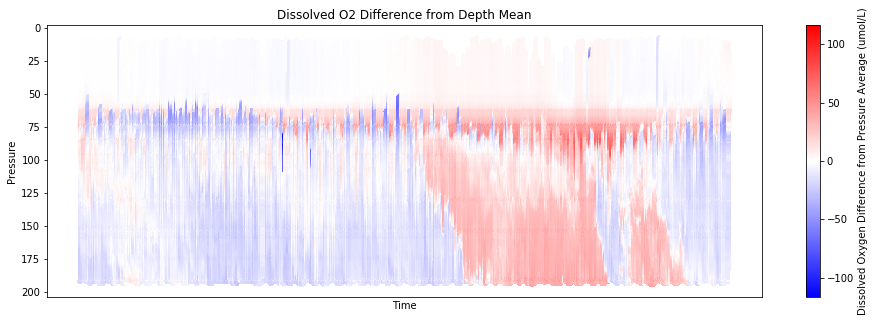

In [145]:
step = 1 # remember from before...
fig = plt.figure(figsize=(16,5))
s = plt.scatter(frame.index[::step], # x
            frame["seawater_pressure"][::step], # y
            s=10, # thickness
            c=frame2[::step], # color map
            norm=norm,
            cmap=plt.get_cmap("bwr")) # color style
plt.gca().invert_yaxis()
plt.ylabel("Pressure")
plt.xlabel("Time")
plt.title("Dissolved O2 Difference from Depth Mean")
plt.tick_params(
    axis = "x",
    which="both",
    bottom = False,
    top = False,
    labelbottom=False)
cb = plt.colorbar(s)
cb.set_label("Dissolved Oxygen Difference from Pressure Average (umol/L)")

This depth comparison reveals an interesting oxygen-rich time period towards the end of the dataset. I wonder if that's anomalous, or just a typical variation. See if you can find out. Pick a different CTD on the array or a larger time range (the data goes back to 2014-15 ish). Good luck!